## Convolution neural network
### Непосредственно сама модель

In [3]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64*64*64, 128)
        self.fc2 = nn.Linear(128, 5)

        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64*64*64)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

### Гиперпараметры и загрузка датасета

In [4]:
num_epochs = 20
num_classes = 5
batch_size = 64
learning_rate = 0.002

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

width_min, height_min = 512, 512


transform = transforms.Compose([transforms.Resize((width_min, height_min)), transforms.ToTensor()])
#    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])])
# data = datasets.ImageFolder('preprocessed/train', transform=transform)
data = datasets.ImageFolder('preprocessed/test', transform=transform)
val = datasets.ImageFolder('preprocessed/val', transform=transform)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train, test = torch.utils.data.random_split(data, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

model = SimpleCNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

### Обучение модели

In [21]:
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0
    for data, target in trainloader:
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    train_loss = train_loss/len(trainloader.dataset)

    print(f'Epoch: {epoch+1} \tTraining Loss: {train_loss:.6f}')

Epoch: 1 	Training Loss: 0.931146
Epoch: 2 	Training Loss: 0.865907
Epoch: 3 	Training Loss: 0.879230
Epoch: 4 	Training Loss: 0.871037
Epoch: 5 	Training Loss: 0.872504
Epoch: 6 	Training Loss: 0.875532
Epoch: 7 	Training Loss: 0.862555
Epoch: 8 	Training Loss: 0.861406
Epoch: 9 	Training Loss: 0.857835
Epoch: 10 	Training Loss: 0.859275
Epoch: 11 	Training Loss: 0.857368
Epoch: 12 	Training Loss: 0.858628
Epoch: 13 	Training Loss: 0.861891
Epoch: 14 	Training Loss: 0.855351
Epoch: 15 	Training Loss: 0.839150
Epoch: 16 	Training Loss: 0.816477
Epoch: 17 	Training Loss: 0.777480
Epoch: 18 	Training Loss: 0.734463
Epoch: 19 	Training Loss: 0.669453
Epoch: 20 	Training Loss: 0.609218


### Тестирование

In [8]:
y_test, predictions = [], []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    
    print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.3f} %')

Accuracy of the network on the 1600 test images: 85.812 %


### Сохраним модель на всякий случай

In [23]:
torch.save(model.state_dict(), f'models/cnn_8k_acc{int(100 * correct / total)}_epoch{num_epochs}_final.pth')

### Оценка метрик

Precision: 96.293 %
Recall: 99.911 %
F1 Score: 98.068 %
F1 Macro Score: 71.997 %
F1 Weighted Score: 84.568 %


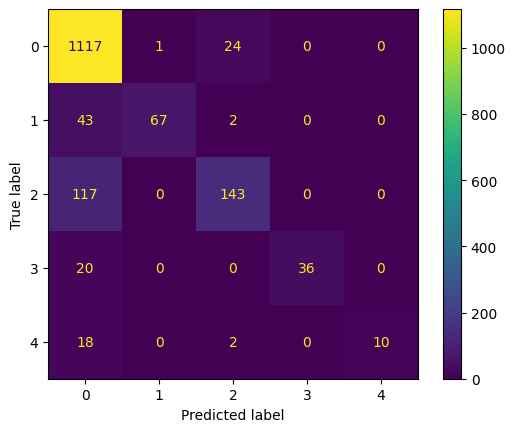

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, predictions)
ax = ConfusionMatrixDisplay(cm).plot()


precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])

f1_score = 2 * precision * recall / (precision + recall)
f1_macro = metrics.f1_score(y_test, predictions, average='macro')
f1_weighted = metrics.f1_score(y_test, predictions, average='weighted')
print(f'Precision: {100 * precision:.3f} %')
print(f'Recall: {100 * recall:.3f} %')
print(f'F1 Score: {100 * f1_score:.3f} %')
print(f'F1 Macro Score: {100 * f1_macro:.3f} %')
print(f'F1 Weighted Score: {100 * f1_weighted:.3f} %')

### Эта модель с таким же гиперпараметрами, но почему то иногда работает лучше

Accuracy of the network on the 1600 test images: 85.812 %
Precision: 96.293 %
Recall: 99.911 %
F1 Score: 98.068 %
F1 Macro Score: 71.997 %
F1 Weighted Score: 84.568 %


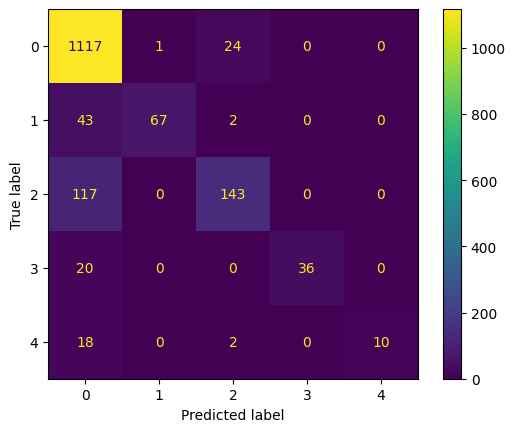

In [10]:
model.load_state_dict(torch.load('models/cnn_8k_acc67_epoch20.pth'))
criterion = nn.CrossEntropyLoss()
model.eval()
model.to(device)

y_test, predictions = [], []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    
    print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.3f} %')

cm = confusion_matrix(y_test, predictions)
ax = ConfusionMatrixDisplay(cm).plot()


precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])

f1_score = 2 * precision * recall / (precision + recall)
f1_macro = metrics.f1_score(y_test, predictions, average='macro')
f1_weighted = metrics.f1_score(y_test, predictions, average='weighted')
print(f'Precision: {100 * precision:.3f} %')
print(f'Recall: {100 * recall:.3f} %')
print(f'F1 Score: {100 * f1_score:.3f} %')
print(f'F1 Macro Score: {100 * f1_macro:.3f} %')
print(f'F1 Weighted Score: {100 * f1_weighted:.3f} %')

### Эта модель была обучена на большом датасете из 35 тысяч картинок, точно лучше работающая, потому что видела все возможные изображения :P

Accuracy of the network on the 1600 test images: 95.625 %
Precision: 98.779 %
Recall: 99.912 %
F1 Score: 99.342 %
F1 Macro Score: 94.237 %
F1 Weighted Score: 95.523 %


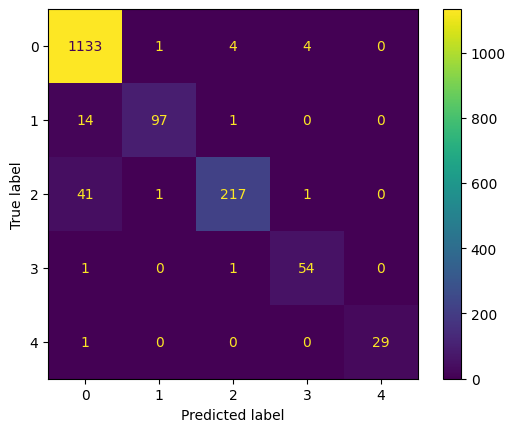

In [11]:
model.load_state_dict(torch.load('models/cnn_35k_acc93_epoch11.pth'))
criterion = nn.CrossEntropyLoss()
model.eval()
model.to(device)

y_test, predictions = [], []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_test.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    
    print(f'Accuracy of the network on the {total} test images: {100 * correct / total:.3f} %')

cm = confusion_matrix(y_test, predictions)
ax = ConfusionMatrixDisplay(cm).plot()


precision = cm[0][0] / (cm[0][0] + cm[1][0])
recall = cm[0][0] / (cm[0][0] + cm[0][1])

f1_score = 2 * precision * recall / (precision + recall)
f1_macro = metrics.f1_score(y_test, predictions, average='macro')
f1_weighted = metrics.f1_score(y_test, predictions, average='weighted')
print(f'Precision: {100 * precision:.3f} %')
print(f'Recall: {100 * recall:.3f} %')
print(f'F1 Score: {100 * f1_score:.3f} %')
print(f'F1 Macro Score: {100 * f1_macro:.3f} %')
print(f'F1 Weighted Score: {100 * f1_weighted:.3f} %')

### Спасибо за внимание